In [128]:
## CE 295 - Energy Systems and Control
#   HW 3 : Optimal Economic Dispatch in Distribution Feeders with Renewables
#   Oski Bear, SID 18681868
#   Prof. Moura
#   Last updated: February 25, 2018

# BEAR_OSKI_HW3.ipynb

import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

In [129]:
## 13 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array([0,0.2,0,0.4,0.17,0.23,1.155,
                0,0.17,0.843,0,0.17,0.128
                ])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array([0,0.116,0,0.29,0.125,0.132,0.66,
                0,0.151,0.462,0,0.08,0.086
                ])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array([5,0,0,3,0,0,0,0,0,3,0,0,0])

# c_j: Marginal generation cost [USD/MW]
c = np.array([100,0,0,150,0,0,0,0,0,50,0,0,0])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array([
    [0, 0.007547918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.0041, 0, 0.007239685, 0, 0.007547918, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.004343811, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0.003773959, 0, 0, 0.004322245, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00434686, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004343157, 0.01169764],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

# x_ij: Reactance [p.u.]
x = np.array([
    [0, 0.022173236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.0064, 0, 0.007336076, 0, 0.022173236, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.004401645, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0.011086618, 0, 0, 0.004433667, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002430473, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004402952, 0.004490848],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

# I_max_ij: Maximal line current [p.u.]
I_max = np.array([
    [0, 3.0441, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1.4178, 0, 0.9591, 0, 3.0441, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 3.1275, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.9591, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3.0441, 3.1275, 0, 0.9591, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.37193, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9591, 1.2927],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j

#TODO I thought this was a connectivity matrix, but it is directed. Should be 1 if parent of i, in the direction of 0.
A = np.array([
    [1,1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,1,0,1,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,1,1,0,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,1,1],
    [0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0]])

### Set Data
# List of node indices
j_idx = np.arange(13)

# \rho(j): Parent node of node j
rho = np.array([0,0,1,2,1,4,1,6,6,8,6,10,10])

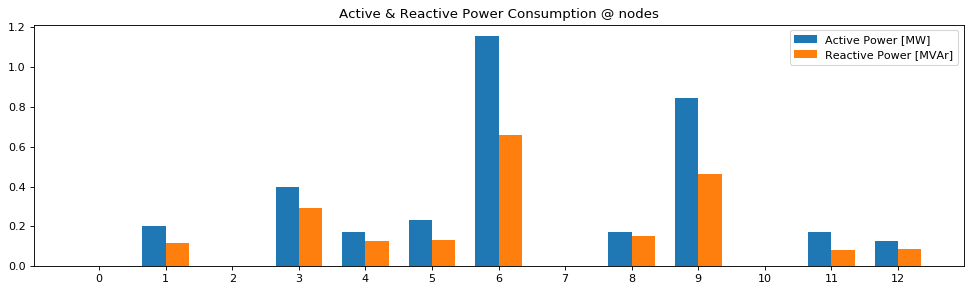

In [130]:
## Problem 1

# Plot active and reactive power consumption
fig, ax = plt.subplots(figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')

bar_width = 0.35
# create plot
active_node   = ax.bar(j_idx - bar_width/2,l_P,bar_width,label='Active Power [MW]')
reactive_node = ax.bar(j_idx + bar_width/2,l_Q,bar_width,label='Reactive Power [MVAr]')

ax.set_title('Active & Reactive Power Consumption @ nodes')
ax.set_ylabel('')
ax.set_xticks(j_idx)
ax.legend()
plt.show()

Problem #2
***
Start simple: In this problem, we will optimally dispatch our generators to minimize cost, while disregarding
the network completely. That is, we seek to balance active & reactive power supply & demand, while
minimizing generation cost and completely ignoring line losses and constraints.

- (a) What are the optimization variables?
  - $p_i,q_i,s_i$
- (b) Write down the objective function, using the notation in Table 1.
    -  minimize the cost of power generated $\sum_{n = i} s_i c_i$ across all nodes.
      -  $\sum\limits_{n \in i} s_i c_i$
- (c) Write down ALL the constraints, using the notation from Table 1. Label the physical meaning of each
constraint. For this problem, ignore voltages and all constraints associated with line flows.
  - Inequality constraints:
    - Supply must meet demand:
      - $p_j \ge 0$
      - $q_j \ge 0$
    - Apparent power generated must be less than or equal to it's rated generation capacity
       - $s \le s_{max}$
    - Apparent power should be equal to the following eq of real and reactive power:
       - $\sqrt{p_{j}^2 + q_{j}^2} = s_j$
  - Equality constraints:
    - The sum of all active and reactive power consumption @ all nodes must equal the sum of the generation @ all nodes of these powers, respectively.
      - $\sum\limits_{n \in i}l_{i}^{P} = \sum\limits_{n \in i}p_i$ 
      - $\sum\limits_{n \in i}l_{i}^{Q} = \sum\limits_{n \in i}q_i$
- (d) Is this a linear program (LP), quadratic program (QP), or convex program (CP)? Why or why not?
What happens when we relax (6) from an equality constraint to an inequality (≤) constraint?
   - Everything is linear except the $\sqrt{p_{j}^2 + q_{j}^2} = s_j$. It doesnt appear to be LP,QP,CP. However, if we switch (6) an inequality than it becomes a CP. 
- (e) Code and numerically solve this problem in Matlab or Python using cvx or cvxpy, respectively. Use
the relaxed version of (6), so your optimization program is convex. In your report provide (i) the
optimal active & reactive generator powers, and (ii) the minimum generating cost.
  - Minimum Generating Cost : 255.36 USD
  - Node 0 Grid  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW
  - Node 3 Gas   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW
  - Node 9 Solar Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW
  - Total active power   : 3.466 MW   consumed | 3.466 MW   generated
  - Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
  - Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated

In [131]:
## Problem 2

# Assumptions:
#   - Disregard the entire network diagram
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13,'active power generation')
q = Variable(13,'reactive power generation')
s = Variable(13,'apparent power generation')

# Define objective function
objective = Minimize(sum(s * c))
# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P), sum(q) == sum(l_Q)]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj] >= 0, q[jj] >= 0]
    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj], q[jj]))) <= s[jj]] #this is the relaxed form
# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()


print(f'------------------- PROBLEM 2 --------------------\n'\
    f'--------------------------------------------------\n'\
    f'{prob2.status}\n'\
    f'Minimum Generating Cost : {prob2.value:4.2f} USD\n'\
    f'\n'\
    f'Node 0 [Grid]  Gen Power : p_0 = {p[0].value:1.3f} MW | q_0 = {q[0].value:1.3f} MW | s_0 = {s[0].value:1.3f} MW\n'\
    f'Node 3 [Gas]   Gen Power : p_3 = {p[3].value:1.3f} MW | q_3 = {q[3].value:1.3f} MW | s_3 = {s[3].value:1.3f} MW\n'\
    f'Node 9 [Solar] Gen Power : p_9 = {p[9].value:1.3f} MW | q_9 = {q[9].value:1.3f} MW | s_9 = {s[9].value:1.3f} MW\n'\
    f'\n'\
    f'Total active power   : {np.sum(l_P):1.3f} MW   consumed | {np.sum(p.value):1.3f} MW   generated\n'\
    f'Total reactive power : {np.sum(l_Q):1.3f} MVAr consumed | {np.sum(q.value):1.3f} MVAr generated\n'\
    f'Total apparent power : {np.sum(l_S):1.3f} MVA  consumed | {np.sum(s.value):1.3f} MVA  generated\n'\
)

# #Output Results
# print( "------------------- PROBLEM 2 --------------------")
# print( "--------------------------------------------------")
# print( prob2.status)
# print( "Minimum Generating Cost : %4.2f"%(prob2.value),"USD")
# print( " ")
# print( "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW")
# print( "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW")
# print( "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW")
# print( " ")
# print( "Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
# print( "Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
# print( "Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

SyntaxError: unmatched ')' (<ipython-input-131-f37095a7e0f4>, line 18)

***
Problem #3
Next, we add line power flows Pij , Qij but still neglect the nodal voltage Vj and Lij terms.

- (a) What are the optimization variables?
  - $p_i,q_i,s_i, P_{ij}, Q_{ij}$
- (b) Write down ALL the constraints, using the notation from Table 1. Label the physical meaning of each
constraint. For this problem, ignore (3)-(4) and drop the Lij terms from (1)-(2).
  - Inequality constraints:
     - Apparent power generated must be less than or equal to it's rated generation capacity
       - $s \le s_{max}$
     - Apparent power must be less than or equal to the following eq of real and reactive power:
       - $\sqrt{p_{j}^2 + q_{j}^2} \le s_j$
  - Equality constraints:
    - Active and Reactive power flowing on the lines must equal the following: 
      - $P_{ij} = (l^{P}_j - p_j) + \sum\limits_{k \in N}A_{jk}P_{jk}$
      - $Q_{ij} = (l^{P}_j - q_j) + \sum\limits_{k \in N}A_{jk}P_{jk}$
- (c) Code and numerically solve this problem in Matlab or Python using cvx or cvxpy, respectively. In your
report provide (i) the optimal active & reactive generator powers, and (ii) the minimum generating
cost. Should the minimum and minimizers be different or the same as Problem 2? Why?
  - Minimum Generating Cost : 255.36 USD
  - Active Generators:
    - Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 =   0 USD/MW
    - Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW
  - The minimum is the still the same, and the minimizers are the same, but we've added P and Q as well. However, becuase we are not using x_ij *L_ij and r_ij *L_ij, there is no penalty for using the network, so P and Q are more just tracking where power is flowing.

Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated
  
- (d) In your code, declare a dual variable µs corresponding to the inequality (7). Re-compute the optimal
solution and dual variable
  - because this is in already included in cvxpy, we call it out in our results already.


In [132]:
## Problem 3

# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13,'active power generation')
q = Variable(13,'reactive power generation')
s = Variable(13,'apparent power generation')
P = Variable((13,13),'active power on line')
Q = Variable((13,13),'reactive power on line')
# Define objective function
objective = Minimize(s * c.T)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    # Non-negative power generation
    #constraints += [p[jj] >= 0, q[jj] >= 0] #Is this captured below?
    # Line Power Flows 
    # constraints += [P[i,jj] == (l_P[jj] - p[jj]) + sum(A[jj,:] * P[jj,:]),
    #                 Q[i,jj] == (l_Q[jj] - q[jj]) + sum(A[jj,:] * Q[jj,:])
    #                 ]
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + A[jj,:] @ P[jj,:],
                    Q[i,jj] == (l_Q[jj] - q[jj]) + A[jj,:] @ Q[jj,:]
                    ]
    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj], q[jj]))) <= s[jj]]

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results

#Python 3 print statement
print(f'------------------- PROBLEM 3 --------------------\n'\
    f'--------------------------------------------------\n'\
    f'{prob3.status}\n'\
    f'Minimum Generating Cost : {prob3.value:4.2f} USD\n'\
    f'\n'\
    f'Node 0 [Grid]  Gen Power : p_0 = {p[0].value:1.3f} MW | q_0 = {q[0].value:1.3f} MW | s_0 = {s[0].value:1.3f} MW || mu_s0 = {constraints[0].dual_value[0]:3.0f} USD/MW \n'\
    f'Node 3 [Gas]   Gen Power : p_3 = {p[3].value:1.3f} MW | q_3 = {q[3].value:1.3f} MW | s_3 = {s[3].value:1.3f} MW || mu_s4 = {constraints[0].dual_value[3]:3.0f} USD/MW \n'\
    f'Node 9 [Solar] Gen Power : p_9 = {p[9].value:1.3f} MW | q_9 = {q[9].value:1.3f} MW | s_9 = {s[9].value:1.3f} MW || mu_s9 = {constraints[0].dual_value[9]:3.0f} USD/MW \n'\
    f'\n'\
    f'Total active power   : {np.sum(l_P):1.3f} MW   consumed | {np.sum(p.value):1.3f} MW   generated\n'\
    f'Total reactive power : {np.sum(l_Q):1.3f} MVAr consumed | {np.sum(q.value):1.3f} MVAr generated\n'\
    f'Total apparent power : {np.sum(l_S):1.3f} MVA  consumed | {np.sum(s.value):1.3f} MVA  generated\n'\
)


# Python 2.x Print statements
# print( "------------------- PROBLEM 3 --------------------")
# print( "--------------------------------------------------")
# print( prob3.status)
# print( "Minimum Generating Cost : %4.2f"%(prob3.value),"USD")
# print( " ")
# print( "Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
# print( "Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
# print( "Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
# print( " ")
# print( "Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
# print( "Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
# print( "Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD

Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 =   0 USD/MW 
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW 
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW 

Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated



***
Problem #4
The Complete Optimal Economic Dispatch with DistFlow Equations
Now we add the nodal voltages Vj , squared current magnitudes Lij , and their bounds (8)-(9). This incorporates impedance (i.e. losses) across the network, along with nodal voltage and line transmission limits.
- (a) What are the optimization variables?
  - $p_j, q_j, s_j, P_{ij}, Q_{ij}, L_{ij},V$
- (b) Write down ALL the constraints, using the notation from Table 1. Label the physical meaning of each
constraint.
  - Inequality constraints:
     - Apparent power generated must be less than or equal to it's rated generation capacity
       - $s \le s_{max}$
     - Apparent power must be less than or equal to the following eq of real and reactive power:
       - $\sqrt{p_{j}^2 + q_{j}^2} \le s_j$
     - Line Current must be:
       - $L_{ij} \le I_{ij, max}^2$
     - Node Voltage must stay within min and max bounds:
       - $v_{min}^2 \le V_j \ge v_{max}^2$
  - Equality constraints:
    - Active and Reactive power flowing on the lines must equal the following: 
      - $P_{ij} = (l^{P}_j - p_j) + r_{ij}L_{ij} + \sum\limits_{k \in N}A_{jk}P_{jk}$
      - $Q_{ij} = (l^{P}_j - q_j) + x_{ij}L_{ij} + \sum\limits_{k \in N}A_{jk}P_{jk}$
    - Sq. Magnitude of Current on the line should be:
      - $L_{ij} = \frac{P_{ij}^2 + Q_{ij}^2}{V_j}$
    - Node voltage must be: 
      - $V_j = V_i + (r_{ij}^2 + x_{ij}^2)L_{ij} - 2(r_{ij}P_{ij} + x_{ij}Q_{ij})$
- (c) Is this a convex program (CP)? Why or why not? What happens when we relax (4) from an equality
constraint to an inequality (≥) constraint?
  - with (4) as equality: not convex because (4) is not affine.
  - with (4) relaxed: convex because (4) is now an inequality and thus only needs to be convex, not affine.
- (d) Code and numerically solve this problem in Matlab or Python using cvx or cvxpy, respectively. In your
report provide (i) the optimal active & reactive generator powers, and (ii) the minimum generating
cost. Use vmin = 0.95, vmax = 1.05 as your voltage limits. Is the solution equivalent to the solution in
Problem 3? Why or why not?
  - Minimum Generating Cost : 299.69 USD
  - Active Generators:
    - Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 =   0 USD/MW
    - Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MW | s_9 = 2.290 MW || mu_s9 =   0 USD/MW
  - No, it is more expensive, becuase we are accounting for x, r, and voltage limits, there is a cost to using the network, and thus results in a different dispatch order.
- (e) Use the dual variables to determine which constraints are active. Specifically, identify at which nodes
the voltage constraint (8) and line current constraint (9) are active.
  - Nodes with active dual variables:
     - Node 0: L < I_max**2: 117.925
     - Node 9: L < I_max**2: 22.518
     - The voltage constraint is not active on any nodes.


- (f) Now re-solve the problem with vmin = 0.98, vmax = 1.02 as your voltage limits. In your report provide the optimal active & reactive generator powers, and (ii) the minimum generating cost. Why did the solution change?
 - Minimum Generating Cost : 348.67 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.940 MW | q_0 = 0.174 MW | s_0 = 0.956 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.760 MW | q_3 = 0.518 MW | s_3 = 0.920 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.789 MW | q_9 = 1.450 MW | s_9 = 2.303 MW || mu_s9 =   0 USD/MW

 - Because the voltage range is tighter, we had to activate the gas gen as well, which has a higher marginal cost.


In [133]:
def print_output(problem):
    print("------------------- PROBLEM 4 --------------------")
    print("--------------------------------------------------")
    print(problem.status)
    print("Minimum Generating Cost : %4.2f"%(problem.value),"USD")
    print(" ")
    print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
    print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
    print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
    print(" ")
    print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
    print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
    print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
    print(" ")

    print('Node Information')
    for jj in j_idx:
        i = rho[jj]
        print(f'Node{jj:2.0f} Voltage: {((V[jj].value)**0.5):1.3f} p.u.')
        print('dual variables:')
        print(f'         v_max: {constraints[1].dual_value[jj]:1.3f}')
        print(f'         v_min: {constraints[2].dual_value[jj]:1.3f}')
        print(f'  L < I_max**2: {constraints[3].dual_value[i,jj]:1.3f}\n')
    print('\n\n\n')

In [134]:
## Problem 4

# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13,'active power generation')
q = Variable(13,'reactive power generation')
s = Variable(13,'apparent power generation')
V = Variable(13,'sq. voltage on node')
P = Variable((13,13),'active power on line')
Q = Variable((13,13),'reactive power on line')
L = Variable((13,13),'sq. magnitude of complex current on line')

# Define objective function
objective = Minimize(s * c)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]
# Nodal voltage limits
constraints += [V <= v_max**2, V >= v_min**2]

# Squared line current limits
constraints += [L <= I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (r[i,jj] * L[i,jj]) + A[jj,:] @ P[jj,:],
                    Q[i,jj] == (l_Q[jj] - q[jj]) + (x[i,jj] * L[i,jj]) + A[jj,:] @ Q[jj,:]
                    ]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2) * L[i,jj] - 2 *(r[i,jj] * P[i,jj] + x[i,jj] *Q[i,jj])]
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(P[i,jj], V[jj]) + quad_over_lin(Q[i,jj], V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj], q[jj]))) <= s[jj]]
    

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print_output(prob4)

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = -0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MW | s_9 = 2.290 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node Information
Node 0 Voltage: 1.000 p.u.
dual variables:
         v_max: 0.000
         v_min: 0.000
  L < I_max**2: 117.925

Node 1 Voltage: 0.967 p.u.
dual variables:
         v_max: 0.000
         v_min: 0.000
  L < I_max**2: 0.000

Node 2 Voltage: 0.963 p.u.
dual variables:
         v_max: 0.000
         v_min: 0.000
  L < I_max**2: 0.000

Node 

In [135]:

#solve again with new v_min, v_max
v_max = 1.02
v_min = 0.98

p = Variable(13,'active power generation')
q = Variable(13,'reactive power generation')
s = Variable(13,'apparent power generation')
V = Variable(13,'sq. voltage on node')
P = Variable((13,13),'active power on line')
Q = Variable((13,13),'reactive power on line')
L = Variable((13,13),'sq. magnitude of complex current on line')

# Define objective function
objective = Minimize(s * c)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]
# Nodal voltage limits
constraints += [V <= v_max**2, V >= v_min**2]

# Squared line current limits
constraints += [L <= I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (r[i,jj] * L[i,jj]) + A[jj,:] @ P[jj,:],
                    Q[i,jj] == (l_Q[jj] - q[jj]) + (x[i,jj] * L[i,jj]) + A[jj,:] @ Q[jj,:]
                    ]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2) * L[i,jj] - 2 *(r[i,jj] * P[i,jj] + x[i,jj] *Q[i,jj])]
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(P[i,jj], V[jj]) + quad_over_lin(Q[i,jj], V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj], q[jj]))) <= s[jj]]
    

# Define problem and solve
prob4b = Problem(objective, constraints)
prob4b.solve()

prob4b = Problem(objective, constraints)
prob4b.solve()
print_output(prob4b)

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 348.67 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.940 MW | q_0 = 0.174 MW | s_0 = 0.956 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.760 MW | q_3 = 0.518 MW | s_3 = 0.920 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.789 MW | q_9 = 1.450 MW | s_9 = 2.303 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.489 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.142 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.178 MVA  generated
 
Node Information
Node 0 Voltage: 1.000 p.u.
dual variables:
         v_max: 0.000
         v_min: 0.000
  L < I_max**2: 172.517

Node 1 Voltage: 0.989 p.u.
dual variables:
         v_max: 0.000
         v_min: 0.000
  L < I_max**2: 0.000

Node 2 Voltage: 0.992 p.u.
dual variables:
         v_max: 0.000
         v_min: 0.000
  L < I_max**2: 0.000

Node 3

In [136]:
## Problem 5

# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

